# Lab-11-4 RNN timeseries

In [40]:
import torch
import torch.optim as optim
import numpy as np

In [41]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [42]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [43]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [44]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [45]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.85461328 0.84977455 0.88991824 0.1276508  0.86431866]] -> [0.85460195]
[[0.79944642 0.82170299 0.84824821 0.14488662 0.85738331]
 [0.83422336 0.84075774 0.88938117 0.16607511 0.86333302]
 [0.85288824 0.83711692 0.87445306 0.26645156 0.86269913]
 [0.83439582 0.83881823 0.88048867 0.1638971  0.87850652]
 [0.83770798 0.84732476 0.89460789 0.11309492 0.8737889 ]
 [0.85461328 0.84977455 0.88991824 0.1276508  0.86431866]
 [0.81890497 0.82264564 0.87148169 0.14224254 0.85460195]] -> [0.84837074]
[[0.83422336 0.84075774 0.88938117 0.16607511 0.86333302]
 [0.85288824 0.83711692 0.87445306 0.26645156 0.86269913]
 [0.83439582 0.83881823 0.88048867 0.1638971  0.87850652]
 [0.83770798 0.84732476 0.89460789 0.11309492 0.8737889 ]
 [0.85461328 0.84977455 0.88991824 0.1276508  0.86431866]
 [0.81890497 0.82264564 0.87148169 0.14224254 0.85460195]
 [0.83539627 0.82687502 0.87685153 0.11592722 0.84837074]] -> [0.88794153]
[[0.85288824 0.83711692 0.87445306 0.26645156 0.86269913]
 [0.83439582 0.838818

In [46]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [47]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [48]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038293838501
1 0.18340937793254852
2 0.15106438100337982
3 0.1261231154203415
4 0.10598734766244888
5 0.08915018290281296
6 0.07493706792593002
7 0.06327901780605316
8 0.054496027529239655
9 0.04902385547757149
10 0.04693441092967987
11 0.04731706529855728
12 0.04838264361023903
13 0.04839478060603142
14 0.04633766785264015
15 0.04207771271467209
16 0.036201704293489456
17 0.029662009328603745
18 0.02338656410574913
19 0.018011242151260376
20 0.013800662010908127
21 0.010714655742049217
22 0.008532222360372543
23 0.006976509466767311
24 0.0058244820684194565
25 0.004987422842532396
26 0.004524713382124901
27 0.004554683342576027
28 0.005089898593723774
29 0.005920967552810907
30 0.006684894207865
31 0.007072674576193094
32 0.0069739921018481255
33 0.006471904926002026
34 0.005753521341830492
35 0.005014693830162287
36 0.0043952930718660355
37 0.003953743726015091
38 0.0036766387056559324
39 0.0035109848249703646
40 0.0034013083204627037
41 0.003315107664093375
42 0.003248895052

334 0.0014341564383357763
335 0.0014325982192531228
336 0.0014310461701825261
337 0.0014295006403699517
338 0.0014279611641541123
339 0.0014264286728575826
340 0.0014249022351577878
341 0.001423381851054728
342 0.001421867753379047
343 0.0014203597093001008
344 0.0014188580680638552
345 0.0014173624804243445
346 0.0014158727135509253
347 0.001414389000274241
348 0.0014129112241789699
349 0.0014114397345110774
350 0.0014099740656092763
351 0.0014085142174735665
352 0.00140706030651927
353 0.0014056124491617084
354 0.0014041706454008818
355 0.0014027345459908247
356 0.0014013039181008935
357 0.0013998800422996283
358 0.0013984614051878452
359 0.0013970490545034409
360 0.0013956426410004497
361 0.0013942418154329062
362 0.0013928472762927413
363 0.0013914586743339896
364 0.0013900763588026166
365 0.001388699864037335
366 0.001387329655699432
367 0.001385965384542942
368 0.0013846075162291527
369 0.001383255934342742
370 0.0013819104060530663
371 0.0013805716298520565
372 0.001379239140078

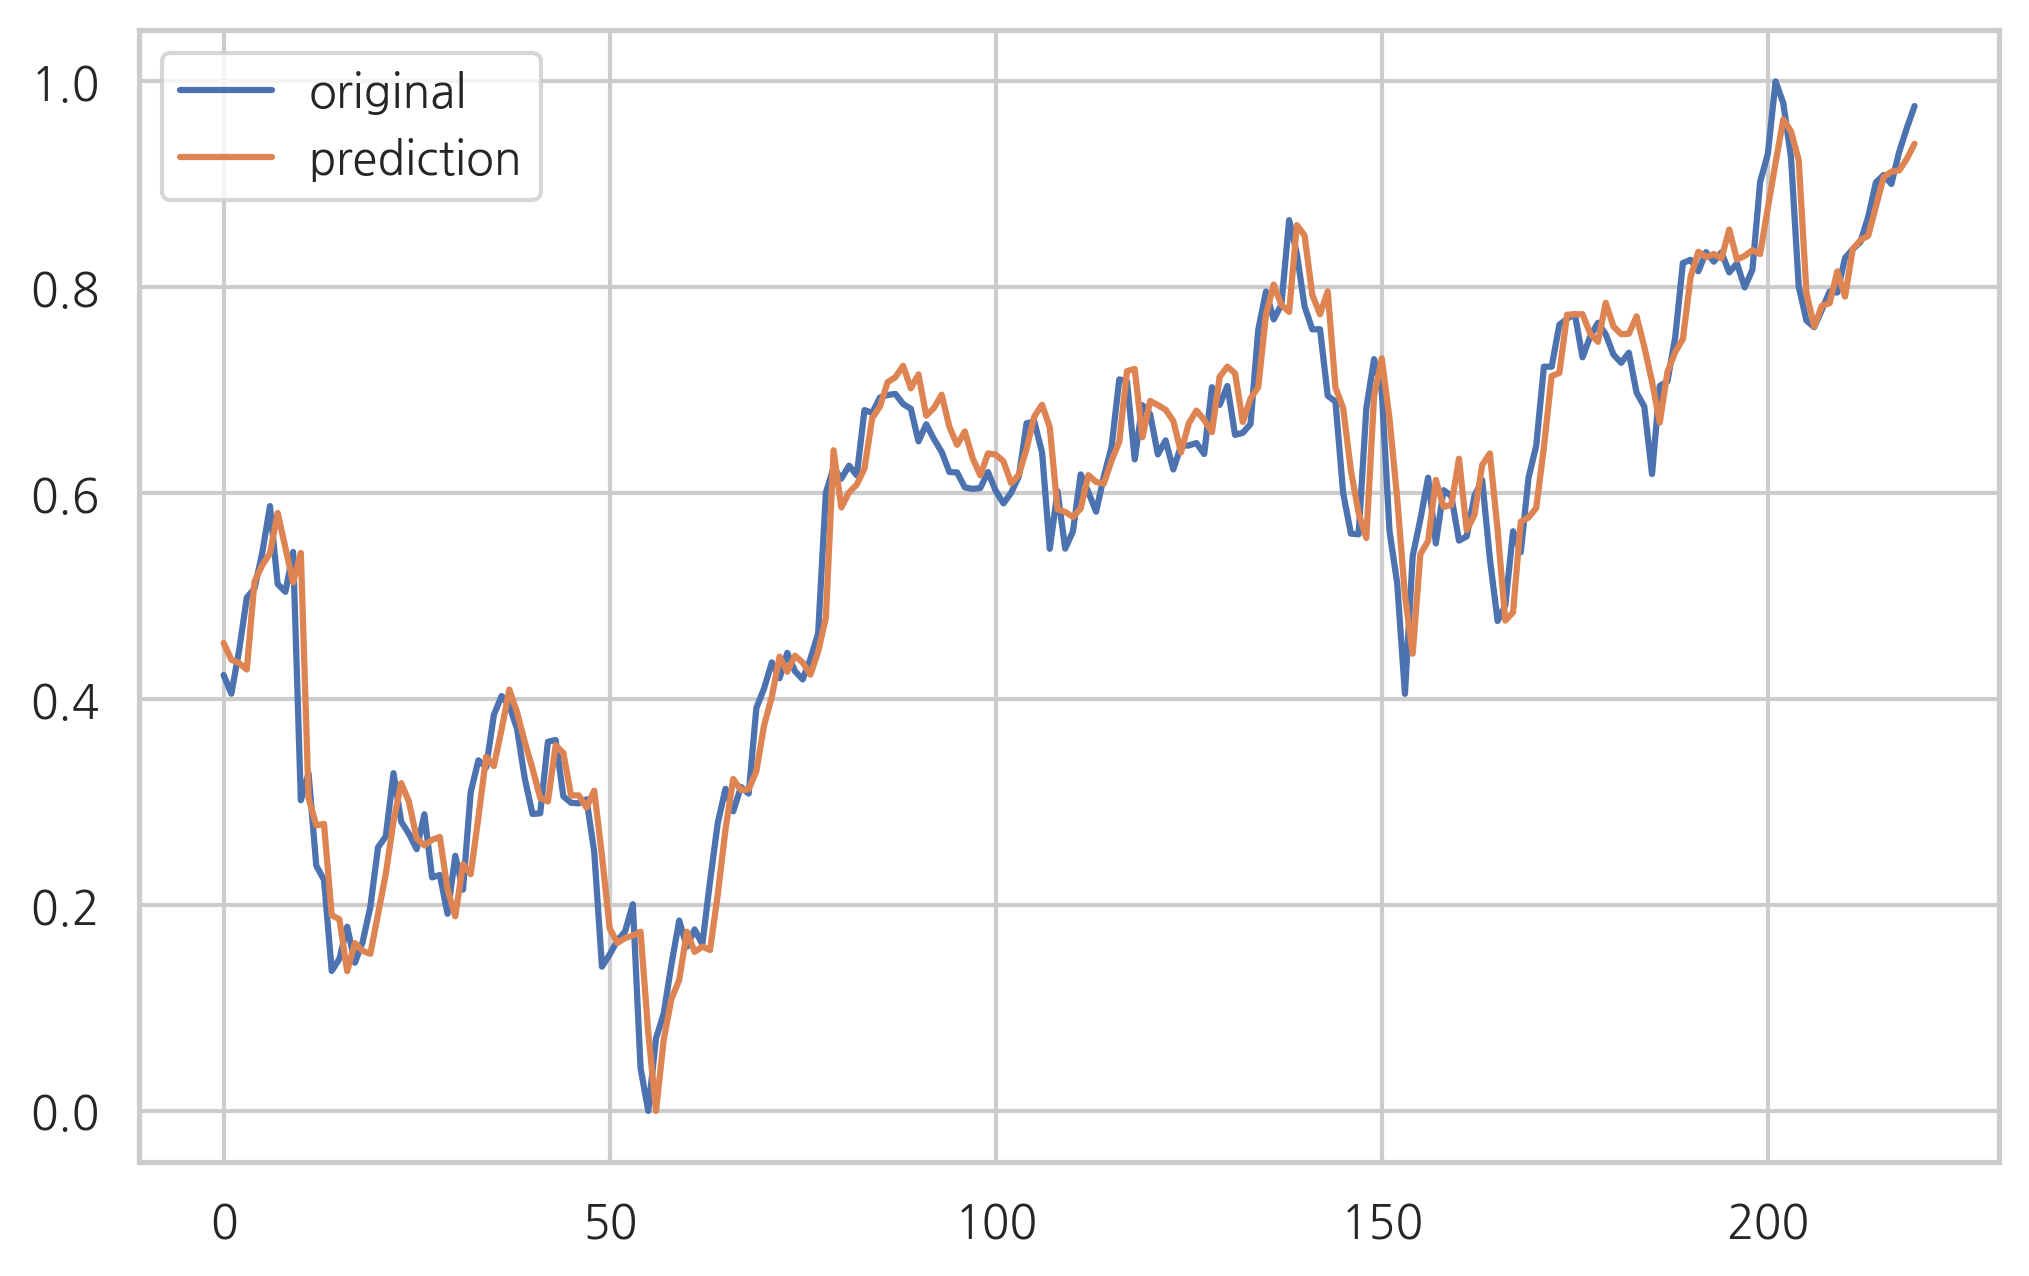

In [49]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()